In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import scipy.stats
import matplotlib.pyplot as plt
from sglm.helpers import filehelpers as fh, dfhelpers as dfh


In [4]:
base_alignment_lst = [
    'SIr', 'SInr',
    'SIAA', 'SIAa',
    'SIAB', 'SIAb',
    'SIaA', 'SIaa',
    'SIaB', 'SIab',
]

In [5]:
def update_max_min(mx_val, mn_val, new_val_mx, new_val_mn):
    mx_chg = new_val_mx > mx_val
    mn_chg = new_val_mn < mn_val
    
    ret_mx = new_val_mx if mx_chg else mx_val
    ret_mn = new_val_mn if mn_chg else mn_val
    return ret_mx, ret_mn, mx_chg, mn_chg

C:\Users\Josh\AppData\Local\Temp\ipykernel_22644\1853678645.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Josh\AppData\Local\Temp\ipykernel_22644\1853678645.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Josh\AppData\Local\Temp\ipykernel_22644\1853678645.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Josh\AppData\Local\Temp\ipykernel_22644\1853678645.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


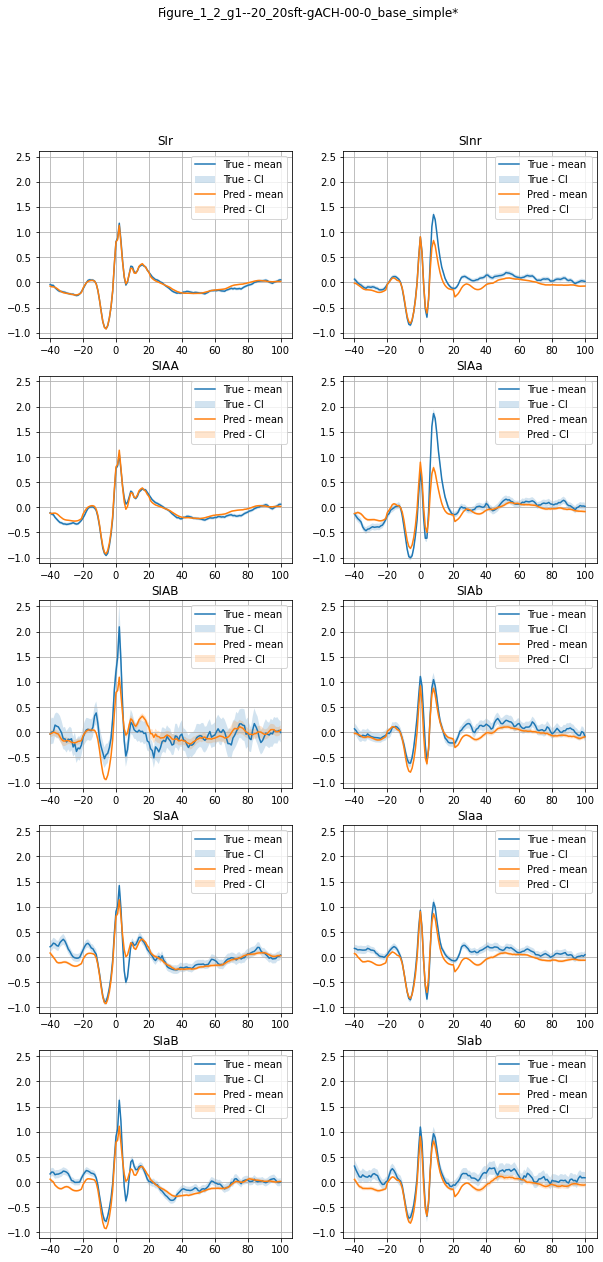

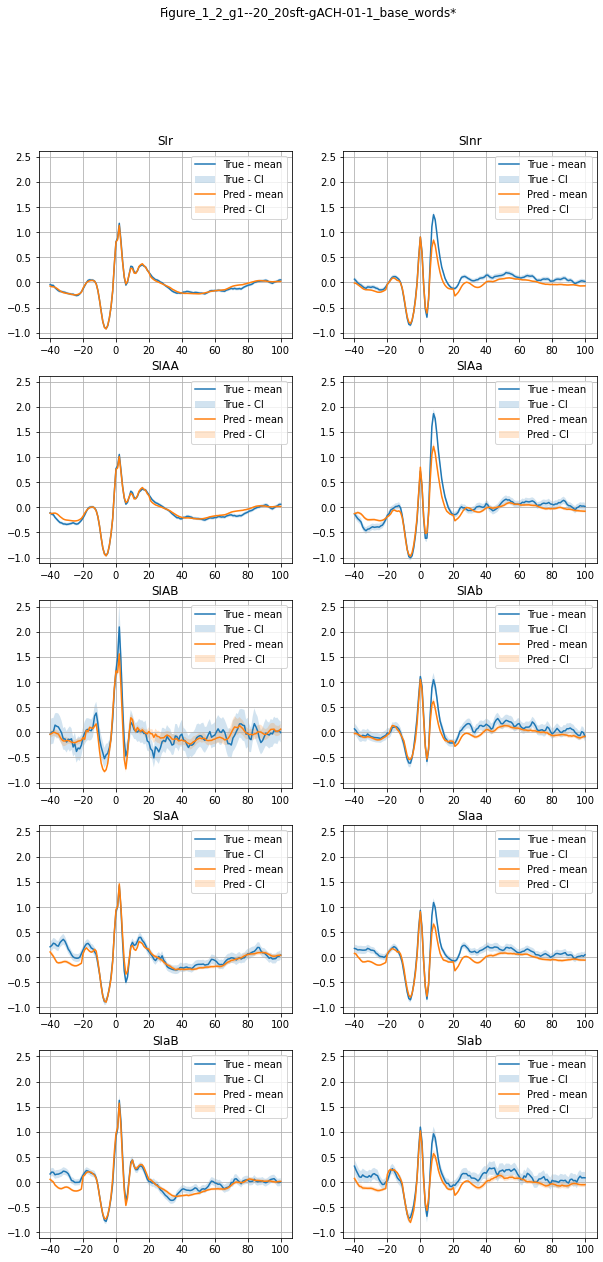

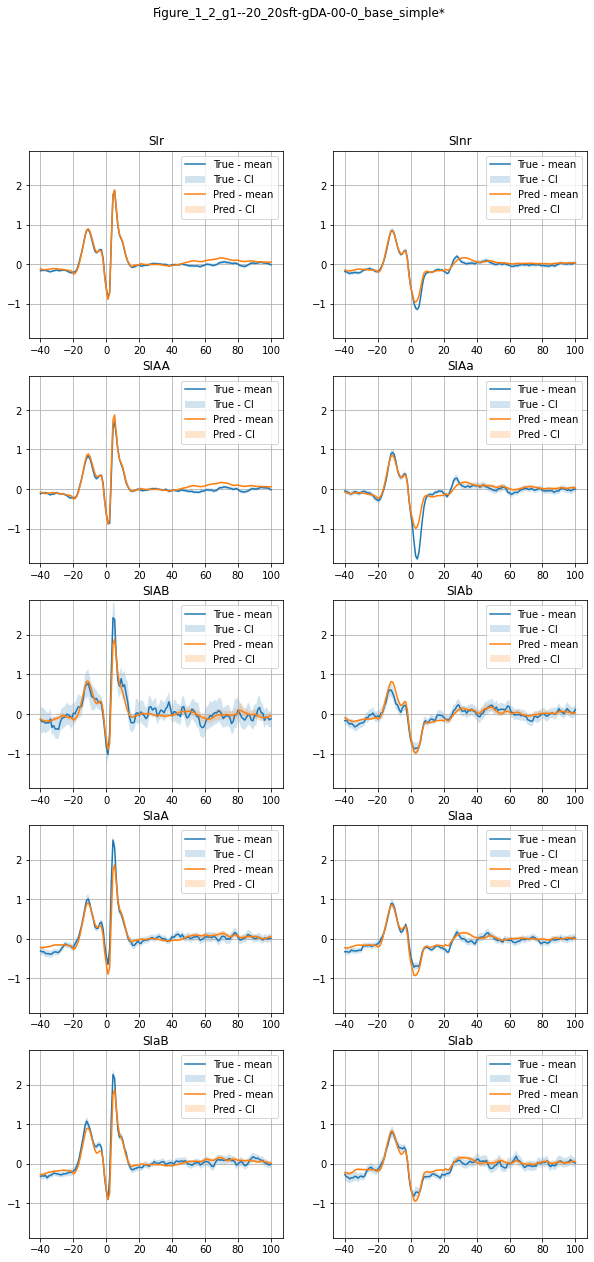

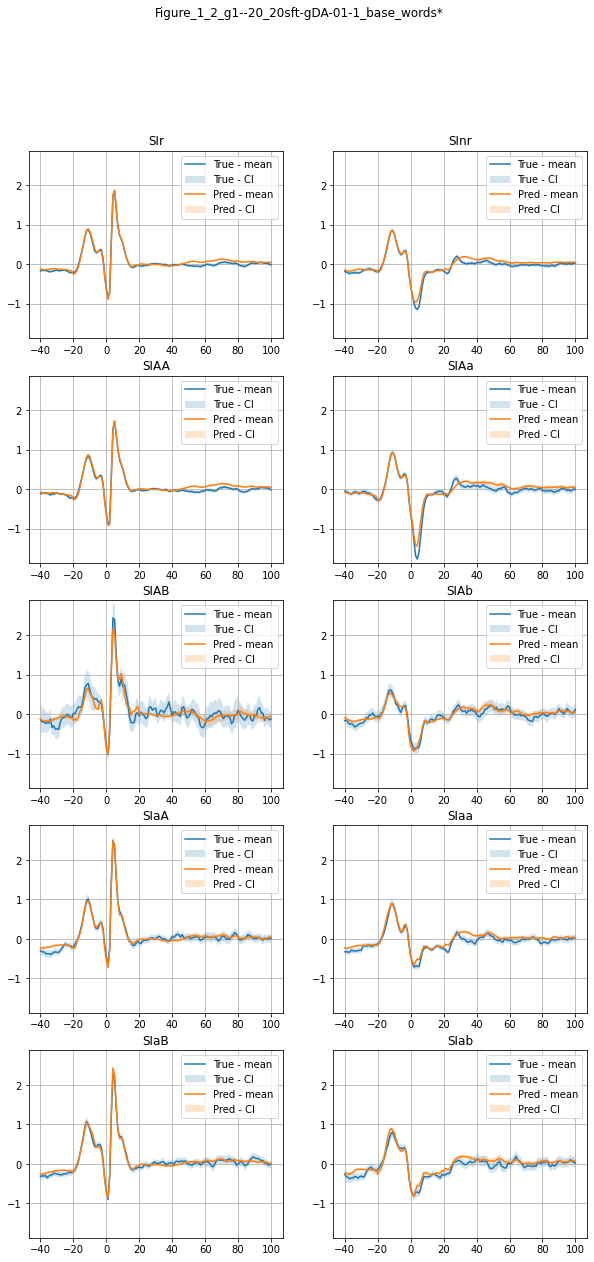

In [6]:
# fig_str_lst = ['Figure_1_2', 'Figure_3', 'Figure_4_g1', 'Figure_4_g2', 'Figure_5_g1', 'Figure_5_g2', 'Figure_5_g5']
# y_col_lst = ['gACH', 'gDA', 'rDA']
# modl_lst_base = ['base_simple', 'base_words']


# fig_str_lst = ['Figure_6_g1']
# fig_str_lst = ['Figure_6_g1-50sft']
# fig_str_lst = ['Figure_6_g1--20_20sft']
fig_str_lst = ['Figure_1_2_g1--20_20sft']
# fig_str_lst = ['Figure_7_g1--20_20sft']
# y_col_lst = ['gGLUr']
y_col_lst = ['gACH', 'gDA']
# y_col_lst = ['gDAc', 'gDAt']
modl_lst_base = ['0_base_simple*', '1_base_words*']


modl_btw_chls = ['gDA_to_gACH', 'rDA_to_gACH', 'gACH_to_gDA', 'gACH_to_rDA']
modl_btw_chls_smpl = [f'base_simple_{_}' for _ in modl_btw_chls]
modl_btw_chls_wrds = [f'base_words_{_}' for _ in modl_btw_chls]

# dr_in = Path(r'/Users/josh/Downloads/final_outputs')
# dr_out = Path(r'/Users/josh/Desktop/output_fig_folder')

# dr_in = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\final_outputs_rev-reconsplt')
dr_in = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs-old\final_outputs_old-reconsplt-paperfig')

# dr_out = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\final_outputs_fig_folder-recons')
dr_out = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs-old\final_outputs_old_fig_folder-paperfig')

fh.create_folder_if_not_exists(str(dr_out.resolve()))

for fig_str in fig_str_lst:
    for y_col in y_col_lst:
        
        if fig_str == 'Figure_3':
            modl_lst = modl_btw_chls + modl_lst_base + modl_btw_chls_smpl + modl_btw_chls_wrds
        else:
            modl_lst = modl_lst_base
        
        for im, modl in enumerate(modl_lst):
            file_name = f'{fig_str}-reconstruct-{y_col}={modl}.csv'
            file_loc = str((dr_in / file_name).resolve())
            file_loc = glob.glob(file_loc)[0]
            try:
                rdf = pd.read_csv(file_loc, index_col=0)
            except Exception as e:
                print(e)
                continue
            # display(rdf)
            # print(list(rdf.columns))

#             base_alignment_lst = list(set([_.split('_')[0] for _ in rdf.columns]))
            # print(base_alignment_lst)

            fig, axes = plt.subplots(len(base_alignment_lst)//2, 2, figsize=(10,20))
            fig_name = f'{fig_str}-{y_col}-{str(im).zfill(2)}-{modl}'

            fig.suptitle(f'{fig_name}')
            fig.set_facecolor('w')
            
            max_y = -np.inf
            min_y = np.inf
            
            for iba, base_alignment in enumerate(base_alignment_lst):
                ax = axes[iba//2, iba%2]
                
                tmp_mx_y = max(rdf[f'{base_alignment}_T_ub'].max(), rdf[f'{base_alignment}_P_ub'].max())
                tmp_mn_y = min(rdf[f'{base_alignment}_T_lb'].min(), rdf[f'{base_alignment}_P_lb'].min())
                max_y, min_y, _, _ = update_max_min(max_y, min_y, tmp_mx_y, tmp_mn_y)

                ax.plot(rdf.index, rdf[f'{base_alignment}_T_mn'], label='True - mean')
                ax.fill_between(rdf.index, rdf[f'{base_alignment}_T_lb'], rdf[f'{base_alignment}_T_ub'], alpha=0.2, label='True - CI')

                ax.plot(rdf.index, rdf[f'{base_alignment}_P_mn'], label='Pred - mean')
                ax.fill_between(rdf.index, rdf[f'{base_alignment}_P_lb'], rdf[f'{base_alignment}_P_ub'], alpha=0.2, label='Pred - CI')

                ax.set_title(base_alignment)
                ax.grid(True)
                ax.legend()
            
            for ax in axes.reshape(-1):
                ax.set_ylim(min_y-0.05, max_y+0.05)
            
            fig.show()
            fig.savefig(str((dr_out / (fig_name.replace('*','') + '.png')).resolve()))
    #         break
    #     break
    # break

In [7]:
# run_id_dct[y_col]

In [8]:
file_loc

'C:\\Users\\Josh\\Documents\\GitHub\\sabatinilab-glm\\sglm\\outputs-old\\final_outputs_old-reconsplt-paperfig\\Figure_1_2_g1--20_20sft-reconstruct-gDA=1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0.csv'